# 21點樸克牌(Blackjack)之Off Policy

In [1]:
# 載入相關套件
import numpy as np
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
import sys
from collections import defaultdict
import matplotlib

matplotlib.style.use('ggplot') # 設定繪圖的風格

In [2]:
# 環境
env = BlackjackEnv()

In [3]:
# 隨機策略
def create_random_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
# 貪婪(greedy)策略
def create_greedy_policy(Q):
    def policy_fn(state):
        # 每個行動的機率初始化，均為 0
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        # 最佳行動的機率 = 1 
        A[best_action] = 1.0
        return A
    return policy_fn

In [5]:
# 定義值循環策略，使用重要性加權抽樣
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # 行動值函數
    # 重要性加權抽樣(weighted importance sampling)的累計分母
    C = defaultdict(lambda: np.zeros(env.action_space.n)) 
    
    # 在策略改良時，採貪婪策略
    target_policy = create_greedy_policy(Q)
        
    # 實驗 N 回合
    for i_episode in range(1, num_episodes + 1):
        # 每 1000 回合顯示除錯訊息
        if i_episode % 1000 == 0:
            print(f"\r {i_episode}/{num_episodes}回合.", end="")
            sys.stdout.flush() # 清除畫面

        # 回合(episode)資料結構為陣列，每一項目含 state, action, reward
        episode = []
        state = env.reset()
        # 開始依策略玩牌，最多 100 步驟，中途分出勝負即結束
        for t in range(100):
            # 評估時採用隨機策略
            probs = behavior_policy(state)
            # 以值函數大小作為隨機抽樣比例的分母
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        G = 0.0 # 報酬初始化
        W = 1.0 # 權重初始化
        # 找出走過的所有狀態
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # 累計報酬
            G = discount_factor * G + reward
            # 累計權重
            C[state][action] += W
            # 更新值函數，公式參見書籍
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # 已更新完畢，即跳出迴圈
            if action !=  np.argmax(target_policy(state)):
                break
            # 更新權重
            W = W * 1./behavior_policy(state)[action]
        
    return Q, target_policy

In [6]:
# 執行值循環
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, 
                                       behavior_policy=random_policy)

 500000/500000回合.

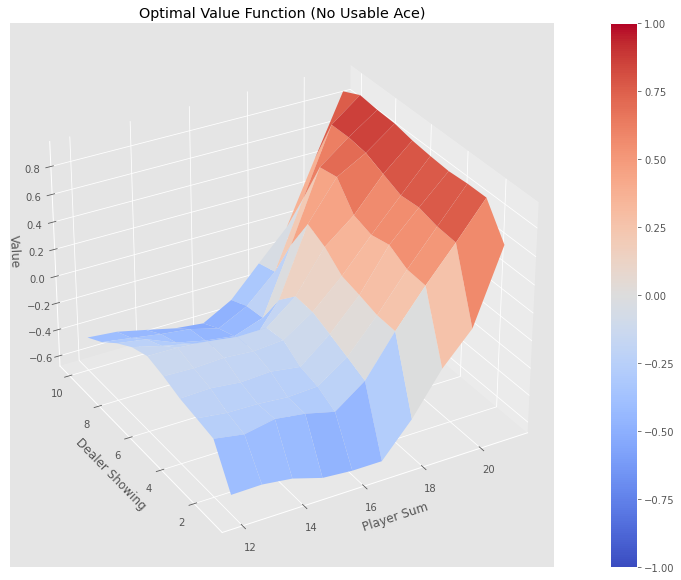

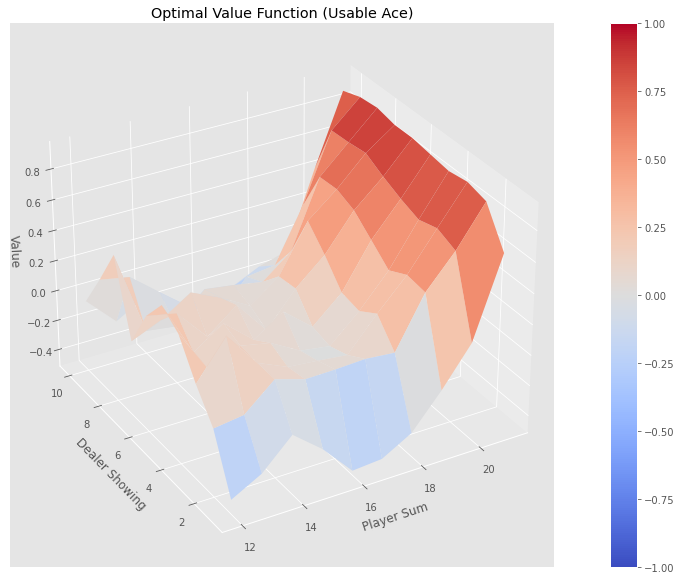

In [7]:
# 顯示結果
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")